In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.metrics import accuracy_score, roc_curve, auc,confusion_matrix,ConfusionMatrixDisplay,f1_score,recall_score,precision_score
import pickle
from sklearn.pipeline import Pipeline


In [10]:
data = pd.read_csv("combo.csv",index_col=0)

In [11]:
data

,Subgroup,1,2,3,4,5,6,7,8,9,...,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834
Array.10,HER2+,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
Array.100,HR+,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.101,HR+,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Array.102,Triple Neg,0,0,0,0,-1,-1,-1,0,-1,...,1,1,1,1,1,1,1,1,1,1
Array.104,Triple Neg,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Array.93,Triple Neg,0,0,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
Array.94,HR+,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.95,HR+,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.98,HR+,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [12]:
y = data.Subgroup
x = data.drop('Subgroup',axis=1)

In [6]:
clf=LinearSVC(random_state=0,dual='auto')

In [7]:
#define the pipeline, I used recursive feature elimination for feature selection. For different feature selection methods you can use 'SelectKBest' instead of RFE, check the documentation of sklearn for instruction
#you can change the 'model' from LinearSVC to other sklearn models
pipe = Pipeline(steps=[('feat_sel', RFE(estimator=LinearSVC(random_state=0,dual='auto',C=0.01),step=100)),
                       ('model', LinearSVC(random_state=0,dual='auto'))])

In [15]:
from sklearn.feature_selection import f_classif, SelectKBest
pipe = Pipeline(steps=[('feat_sel', SelectKBest(score_func=f_classif)),
                       ('model', LinearSVC(random_state=0,dual='auto'))])

In [16]:
#nested cv to estimate the test performance of our training pipeline, repeated 100 times, outer 3-fold cv, inner 5-fold cv
test_score_nested = []
N_TRIALS = 100
param_grid = {'feat_sel__k': [25,50,100],'model__C': [0.01, 0.05, 0.1]}
for i in range(N_TRIALS):  
    inner_cv = StratifiedKFold(5,shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(3,shuffle=True, random_state=i)
    search = GridSearchCV(estimator=pipe, param_grid=param_grid,cv=inner_cv,n_jobs=-1)
    test_score = cross_val_score(search, x, y, cv=outer_cv, n_jobs=-1)
    test_score_nested.append(test_score.mean())

In [17]:
test_score_nested

[0.7795603089720737,
 0.7997623291740937,
 0.7507427213309567,
 0.7994652406417112,
 0.7507427213309565,
 0.7899584076054665,
 0.8104575163398694,
 0.8000594177064766,
 0.8695781342840166,
 0.7694592988710637,
 0.8493761140819963,
 0.8095662507427214,
 0.690136660724896,
 0.7501485442661915,
 0.8401663695781343,
 0.7682709447415329,
 0.7501485442661914,
 0.6898395721925134,
 0.7599524658348189,
 0.8306595365418895,
 0.7712418300653595,
 0.7902554961378491,
 0.7492572786690435,
 0.7495543672014261,
 0.7314319667260843,
 0.7795603089720737,
 0.7501485442661914,
 0.7305407011289363,
 0.7201426024955436,
 0.7896613190730838,
 0.800653594771242,
 0.8199643493761141,
 0.7694592988710637,
 0.7293523469994058,
 0.7703505644682115,
 0.800653594771242,
 0.7097445038621509,
 0.8202614379084968,
 0.6598336304218657,
 0.7311348781937017,
 0.740344622697564,
 0.7795603089720737,
 0.8300653594771242,
 0.749554367201426,
 0.7290552584670232,
 0.8000594177064766,
 0.8003565062388592,
 0.810160427807486

In [18]:
scores=pd.DataFrame(test_score_nested)

<Axes: >

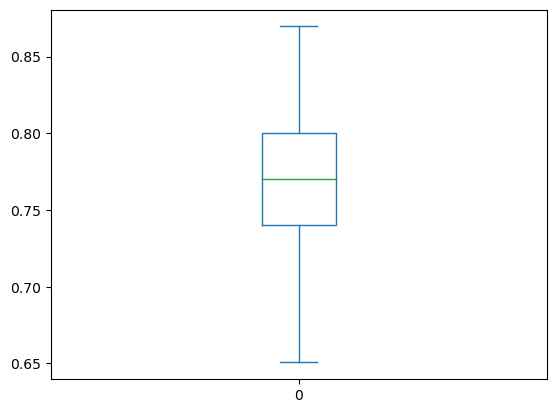

In [19]:
scores.plot.box()

In [12]:
search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=99, shuffle=True),
             estimator=Pipeline(steps=[('feat_sel',
                                        RFE(estimator=LinearSVC(C=0.01,
                                                                dual='auto',
                                                                random_state=0),
                                            step=100)),
                                       ('model',
                                        LinearSVC(dual='auto',
                                                  random_state=0))]),
             n_jobs=-1,
             param_grid={'feat_sel__n_features_to_select': [50, 75, 100],
                         'model__C': [0.01, 0.05, 0.1]})

In [13]:
#search for best hyperparameters on whole train set
search.fit(x,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=99, shuffle=True),
             estimator=Pipeline(steps=[('feat_sel',
                                        RFE(estimator=LinearSVC(C=0.01,
                                                                dual='auto',
                                                                random_state=0),
                                            step=100)),
                                       ('model',
                                        LinearSVC(dual='auto',
                                                  random_state=0))]),
             n_jobs=-1,
             param_grid={'feat_sel__n_features_to_select': [50, 75, 100],
                         'model__C': [0.01, 0.05, 0.1]})

In [14]:
search.best_estimator_

Pipeline(steps=[('feat_sel',
                 RFE(estimator=LinearSVC(C=0.01, dual='auto', random_state=0),
                     n_features_to_select=50, step=100)),
                ('model', LinearSVC(C=0.01, dual='auto', random_state=0))])

In [15]:
search.best_score_

0.85

In [31]:
search.best_estimator_.fit(x,y)

Pipeline(steps=[('feat_sel',
                 RFE(estimator=LinearSVC(C=0.01, dual='auto', random_state=0),
                     n_features_to_select=50, step=100)),
                ('model', LinearSVC(C=0.01, dual='auto', random_state=0))])

In [32]:
#get the best RFE object
rfe=search.best_estimator_['feat_sel']

In [83]:
#get the best model
model=search.best_estimator_['model']

In [34]:
#get the bool values for features
mask=rfe.get_support()
mask

array([False, False, False, ..., False, False, False])

In [35]:
#get the features used by the best model
mask=rfe.get_support()
features=x.columns[mask]

In [36]:
features

Index(['42', '193', '231', '487', '696', '747', '763', '766', '792', '852',
       '855', '856', '1010', '1036', '1092', '1144', '1244', '1560', '1563',
       '1570', '1657', '1664', '1673', '1678', '1679', '1882', '1974', '2018',
       '2022', '2024', '2025', '2027', '2028', '2057', '2114', '2127', '2185',
       '2207', '2208', '2211', '2212', '2214', '2215', '2219', '2516', '2548',
       '2663', '2743', '2751', '2761'],
      dtype='object')

In [37]:
model.classes_

array(['HER2+', 'HR+', 'Triple Neg'], dtype=object)

In [38]:
#Some models like random forest use feature_importance, check the documentation of your model
model.coef_

array([[-3.60265740e-02,  4.07289563e-03, -3.57331702e-02,
        -1.05797825e-01, -1.80825782e-02, -3.76751592e-02,
         6.16866168e-02, -2.80590687e-02,  2.53555393e-02,
         4.50230494e-02,  8.24920314e-02,  7.55334649e-02,
         1.88096032e-02,  2.57648972e-02, -9.89672790e-02,
        -4.93932874e-02, -4.64777151e-02, -4.52202374e-02,
         9.18975365e-03,  6.31264638e-02,  1.81175289e-02,
        -3.07126606e-02,  1.13557042e-02,  6.80759015e-03,
         7.50536708e-03,  5.15906733e-02, -1.02787134e-01,
        -1.79119632e-02,  9.37351803e-02, -1.39108482e-02,
        -1.17380889e-02, -1.43222897e-02, -8.38964225e-03,
        -5.19998540e-02,  7.95759858e-02,  6.50563494e-02,
         3.57767726e-01, -4.24309793e-02, -4.24309793e-02,
        -5.39294953e-02, -6.11364324e-02, -8.21541331e-02,
        -7.44578737e-02, -6.23290702e-02, -3.57139638e-02,
        -4.09742659e-03,  3.69643053e-02,  1.48609878e-01,
         6.69270933e-03, -2.93646164e-02],
       [ 1.18

In [109]:
#Best single predictor for HER2+
features[np.argsort(-model.coef_[0])[0]]

'2185'

In [110]:
#Best single predictor for HR+
features[np.argsort(-model.coef_[1])[0]]

'696'

In [111]:
#Best single predictor for Triple Neg
features[np.argsort(-model.coef_[2])[0]]

'2751'

In [95]:
model.fit(x_important,y)

LinearSVC(C=0.01, dual='auto', random_state=0)

In [96]:
model.coef_

array([[-3.60265740e-02,  4.07289563e-03, -3.57331702e-02,
        -1.05797825e-01, -1.80825782e-02, -3.76751592e-02,
         6.16866168e-02, -2.80590687e-02,  2.53555393e-02,
         4.50230494e-02,  8.24920314e-02,  7.55334649e-02,
         1.88096032e-02,  2.57648972e-02, -9.89672790e-02,
        -4.93932874e-02, -4.64777151e-02, -4.52202374e-02,
         9.18975365e-03,  6.31264638e-02,  1.81175289e-02,
        -3.07126606e-02,  1.13557042e-02,  6.80759015e-03,
         7.50536708e-03,  5.15906733e-02, -1.02787134e-01,
        -1.79119632e-02,  9.37351803e-02, -1.39108482e-02,
        -1.17380889e-02, -1.43222897e-02, -8.38964225e-03,
        -5.19998540e-02,  7.95759858e-02,  6.50563494e-02,
         3.57767726e-01, -4.24309793e-02, -4.24309793e-02,
        -5.39294953e-02, -6.11364324e-02, -8.21541331e-02,
        -7.44578737e-02, -6.23290702e-02, -3.57139638e-02,
        -4.09742659e-03,  3.69643053e-02,  1.48609878e-01,
         6.69270933e-03, -2.93646164e-02],
       [ 1.18

In [80]:
x_important = x[['42', '193', '231', '487', '696', '747', '763', '766', '792', '852',
       '855', '856', '1010', '1036', '1092', '1144', '1244', '1560', '1563',
       '1570', '1657', '1664', '1673', '1678', '1679', '1882', '1974', '2018',
       '2022', '2024', '2025', '2027', '2028', '2057', '2114', '2127', '2185',
       '2207', '2208', '2211', '2212', '2214', '2215', '2219', '2516', '2548',
       '2663', '2743', '2751', '2761']]

In [45]:
with open('linearSVC.pickle', 'wb') as f:
    pickle.dump(search, f)

In [46]:
search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=99, shuffle=True),
             estimator=Pipeline(steps=[('feat_sel',
                                        RFE(estimator=LinearSVC(C=0.01,
                                                                dual='auto',
                                                                random_state=0),
                                            step=100)),
                                       ('model',
                                        LinearSVC(dual='auto',
                                                  random_state=0))]),
             n_jobs=-1,
             param_grid={'feat_sel__n_features_to_select': [50, 75, 100],
                         'model__C': [0.01, 0.05, 0.1]})

In [48]:
with open('LinearSVC_score.pickle', 'wb') as f:
    pickle.dump(test_score_nested, f)

In [10]:
with open('LDA_score.pickle', 'rb') as f:
    lda_score = pickle.load(f)

In [3]:
with open('LinearSVC_score.pickle', 'rb') as f:
    lsvc_score = pickle.load(f)

In [9]:
import statistics
statistics.mean(lsvc_score)

0.8092751039809863

In [13]:
lda_score.mean()

0    0.611384
dtype: float64

In [21]:
lda_score = lda_score.values

NameError: name 'lda_score' is not defined

In [72]:
lda_score = lda_score.flatten()

In [73]:
lsvc_score = scores

In [22]:
lsvc_score=lsvc_score.values

AttributeError: 'list' object has no attribute 'values'

In [23]:
lsvc_score = lsvc_score.flatten()

AttributeError: 'list' object has no attribute 'flatten'

In [30]:
with open('fLinearSVC_score.pickle', 'wb') as f:
    pickle.dump(scores, f)

In [ ]:
with open('fLinearSVC_score.pickle', 'rb') as f:
    flsvc_score = pickle.load(f)

In [25]:
f_score = scores.values
f_score = f_score.flatten()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2eb47aec70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2eb47b3f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2eb47aea00>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2eb47912b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2eb4791250>,
 'means': []}

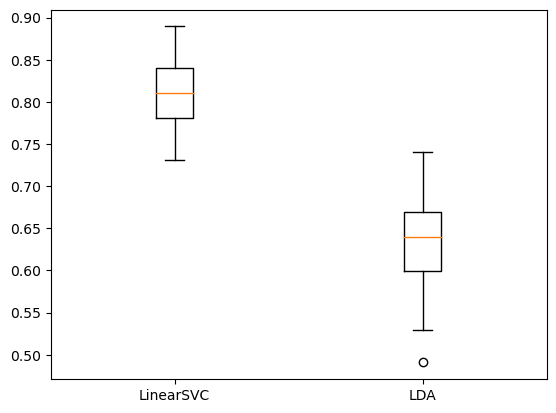

In [77]:
#Comparison of estimated model performance
fig,ax = plt.subplots()
ax.boxplot([lsvc_score,lda_score],labels=['LinearSVC','LDA'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0dc444c250>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0dc444c640>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0dc4442f40>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0dc444cbb0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0dc444c820>,
 'means': []}

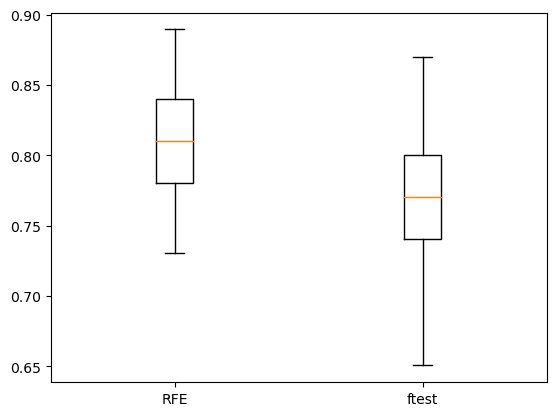

/home/trl293/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [2699] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/trl293/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/trl293/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [2699] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/trl293/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/trl293/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [2699] are constant.
  warnings.warn("Features %s are constant." % const

In [27]:
fig,ax = plt.subplots()
ax.boxplot([lsvc_score,f_score],labels=['RFE','ftest'])

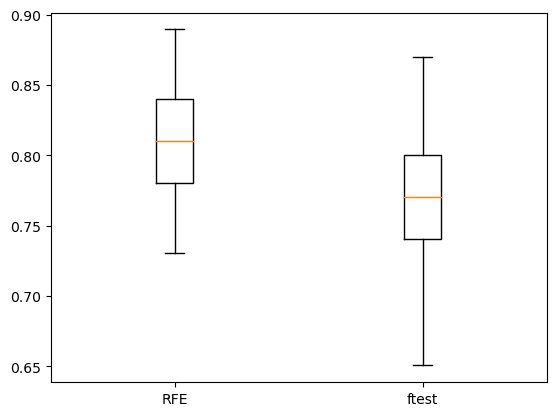

/home/trl293/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [2657] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/trl293/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [2657] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/trl293/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [2657] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/trl293/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/trl293/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encount

In [29]:
fig

In [ ]:
with open('chi2LinearSVC_score.pickle', 'wb') as f:
    pickle.dump(fig,ax, f)